In [1]:
import sys
sys.path.append('..')
# reload local packages automatically
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)

# Import packages.
import cvxpy as cp
import numpy as np

import matplotlib.pyplot as plt


from opentn.transformations import create_kitaev_liouvillians, exp_operator_dt, factorize_psd, super2choi
d, N = 2, 4
dim = d**N
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=1e-2)
tau = 4
superops_exp = []
for i, op in enumerate([Lvec, Lvec_odd, Lvec_even]):
    if i == 1:
        superops_exp.append(exp_operator_dt(op, tau/2, 'jax'))
    else:
        superops_exp.append(exp_operator_dt(op, tau, 'jax'))
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = superops_exp

X1 = factorize_psd(psd=super2choi(exp_Lvec_odd), tol=1e-12)
X2 = factorize_psd(psd=super2choi(exp_Lvec_even), tol=1e-12)

from opentn.optimization import gds, frobenius_norm, model_Ys, compute_loss
cost_n4, grads_n4, xi_n4 = gds(fn=compute_loss, x0=[X1, X2, X1], iter=int(2e3), loss_fn=frobenius_norm, model=model_Ys, rate=1.5e-9, exact = exp_Lvec, show_cost=False)
print(cost_n4[0])
print(cost_n4[-1])

2.6383007149418305e-07
1.4977787039695335e-07


In [2]:
from opentn.transformations import super2choi, choi_composition
from opentn.optimization import small2zero
from scipy import sparse

tol = 1e-12

with open(f'Y1_scs_warm_gds_eps_{tol}.npy', 'rb') as f:
    Y1_cvxpy = np.load(f)
with open(f'Y3_scs_warm_gds_eps_{tol}.npy', 'rb') as f:
    Y3_cvxpy = np.load(f)
# rest of matrices optimized with GSD
X1_gds, X2_gds, X3_gds = xi_n4[-1]
Y1_gds = X1_gds@X1_gds.conj().T
Y2_gds = X2_gds@X2_gds.conj().T
Y3_gds = X3_gds@X3_gds.conj().T

rhs = np.asarray(super2choi(superop=exp_Lvec, dim=dim))
srhs = sparse.csr_matrix(small2zero(rhs, tol=tol)) 
srhs = srhs.astype(np.float64)
C2 = choi_composition(C1=small2zero(Y2_gds, tol=tol), C2=small2zero(Y3_cvxpy, tol=tol), dim=dim) 
print(frobenius_norm(choi_composition(small2zero(Y1_cvxpy, tol=tol), C2), small2zero(rhs, tol=tol))) 

9.518368149400564e-08


/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/scipy/sparse/_data.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  self.data.astype(dtype, casting=casting, copy=True),


In [3]:
# now we optimize the second layer
from opentn.transformations import link_product_cvxpy
Y2_cvxpy = cp.Variable((dim**2,dim**2), PSD=True)
C12 = link_product_cvxpy(C1=small2zero(Y1_cvxpy, tol), C2=Y2_cvxpy, dim=dim, transpose=0, optimization=True)
lhs = link_product_cvxpy(C1=C12, C2=small2zero(Y3_cvxpy, tol), dim=dim, transpose=1, optimization=True)
cost = cp.norm(lhs - srhs, "fro")
prob = cp.Problem(cp.Minimize(cost))
Y2_cvxpy.value = small2zero(Y2_gds, tol=tol).astype(np.float64) 
cost.value

/var/folders/lv/986s3mp97gv9n3rb757bg87m0000gn/T/ipykernel_42071/131929609.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  Y2_cvxpy.value = small2zero(Y2_gds, tol=tol).astype(np.float64)


9.518368146567448e-08

In [4]:
# now I need to test if the new function is faster
from opentn.transformations import choi_composition_3Y_cvxpy

lhs_test = choi_composition_3Y_cvxpy(C1=small2zero(Y1_cvxpy, tol), C2=Y2_cvxpy, C3=small2zero(Y3_cvxpy, tol), dim=dim)
cost_test = cp.norm(lhs_test - srhs, "fro")
cost_test.value

: 

: 

In [4]:
prob.solve(solver=cp.SCS, verbose=True, canon_backend=cp.SCIPY_CANON_BACKEND, eps=tol)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Jul 30 06:45:37 PM: Your problem has 65536 variables, 0 constraints, and 0 parameters.
(CVXPY) Jul 30 06:45:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 30 06:45:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 30 06:45:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 30 06:45:37 PM: Compiling problem (target solver=SCS).
(CVXPY) Jul 30 06:45:37 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jul 30 10:45:44 PM: Problem status: optimal_inaccurate
(CVXPY) Jul 30 10:45:44 PM: Optimal value: 9.476e-08
(CVXPY) Jul 30 10:45:44 PM: Compilation took 9.616e+03 seconds
(CVXPY) Jul 30 10:45:44 PM: Solver (including time spent in interface) took 4.765e+03 seconds


9.476497516415284e-08

In [5]:


with open(f'Y2_scs_warm_gds_eps_{tol}.npy', 'wb') as f:
    np.save(f, Y2_cvxpy.value)



In [7]:
(9.476497516415284e-08)/(2.6383007149418305e-07)

0.35918943821474963

In [8]:
max_idx = 16
for op in [super2choi(exp_Lvec_even), X2@X2.conj().T, Y2_gds, Y2_cvxpy.value, small2zero(Y2_cvxpy.value, tol=tol)]:
    print(np.linalg.matrix_rank(op, tol=tol))
    print(np.sort(np.linalg.svd(op, compute_uv=False))[::-1][:max_idx])
    print('----')

2
[1.59601993e+01 3.98006650e-02 8.04584638e-15 7.44107274e-15
 6.35534243e-15 6.08900421e-15 5.96817584e-15 4.30411352e-15
 4.15110762e-15 4.08426036e-15 3.87104276e-15 3.83801035e-15
 3.61976540e-15 3.40987604e-15 3.35698250e-15 3.24526022e-15]
----
2
[1.59601993e+01 3.98006650e-02 7.85057766e-15 7.70597403e-15
 7.31610439e-15 5.63716522e-15 5.61165715e-15 4.61416318e-15
 4.29008103e-15 3.98876709e-15 3.59203365e-15 3.49654589e-15
 3.34725537e-15 3.24894904e-15 3.13205965e-15 2.49531451e-15]
----
2
[1.59601992e+01 3.98007470e-02 6.93465703e-15 6.08605334e-15
 5.84348722e-15 5.38056704e-15 4.84851075e-15 4.56685770e-15
 4.27488658e-15 4.15471963e-15 3.57685052e-15 3.37556339e-15
 3.00307300e-15 2.90192454e-15 2.81691248e-15 2.63100792e-15]
----
7
[1.59601992e+01 3.98007427e-02 1.18323156e-10 3.68785161e-11
 9.27037444e-12 6.70717031e-12 3.03205543e-12 8.96682266e-13
 3.18805700e-13 6.87273974e-15 4.87495312e-15 4.28494634e-15
 4.13782880e-15 3.98539272e-15 3.68113501e-15 3.24608906e-1

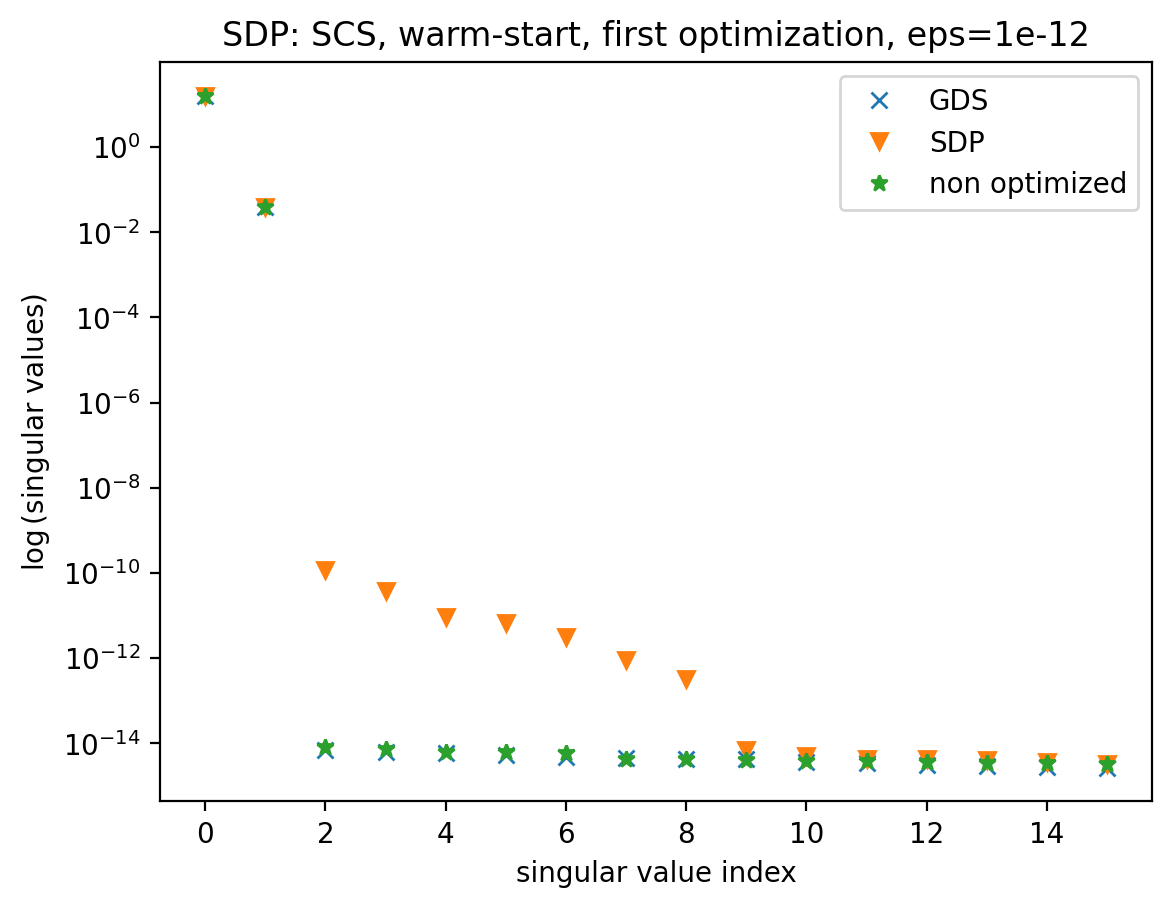

In [9]:
plt.figure(dpi=200)
plt.title(f'SDP: SCS, warm-start, first optimization, eps={tol}')
plt.ylabel(r'$\log$(singular values)')
plt.xlabel(r'singular value index')
plt.semilogy(np.linalg.svd(Y2_gds, compute_uv=False)[:max_idx], 'x', label='GDS')
plt.semilogy(np.linalg.svd(Y2_cvxpy.value, compute_uv=False)[:max_idx], 'v', label='SDP')
plt.semilogy(np.linalg.svd(super2choi(exp_Lvec_even), compute_uv=False)[:max_idx], '*', label='non optimized')
plt.legend()